# EhV

# Package imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [4]:
import copy
import pickle

In [5]:
import numpy
import scipy.stats
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, robust_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.preprocessing import scale, robust_scale, power_transform, normalize

import umap
import umap.plot

from matplotlib.colors import Normalize
from matplotlib.path import Path as mPath
from matplotlib.patches import Polygon

from kneed import KneeLocator

In [6]:
from ehv.core import plot_gate_zarr_channels, SelectFromCollection
from ehv import normalization

In [7]:
import shap
shap.initjs()

In [8]:
import scanpy
import anndata

# Data import

In [9]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [10]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])
df = df[numpy.load(data_dir / "indices/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "indices/iso.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(103775, 914)

In [11]:
selected = df.filter(regex="feat.*(BF|SSC|DAPI)").columns

In [12]:
adata = anndata.AnnData(
    df.filter(regex="feat")[selected], 
    obs=pandas.concat([df.filter(regex="meta"), df.index.to_frame()], axis=1),
    dtype=numpy.float32
)
adata.raw = adata

# Dimensionality reduction

In [13]:
adata.X = adata.to_df().fillna(0)

In [14]:
adata.X = normalization.qq(adata.to_df(), (0.01, 0.99))

In [15]:
adata.var_names[adata.to_df().isna().any()]

Index(['feat_euler_number_BF1', 'feat_euler_number_SSC',
       'feat_euler_number_BF2'],
      dtype='object')

In [16]:
cols = adata.to_df().drop(columns=adata.to_df().filter(regex="euler").columns).columns

In [17]:
adata = adata[:, cols]

In [18]:
scanpy.tl.pca(adata)

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


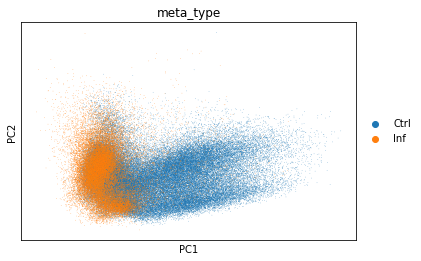

In [19]:
scanpy.pl.pca(adata, color="meta_type")

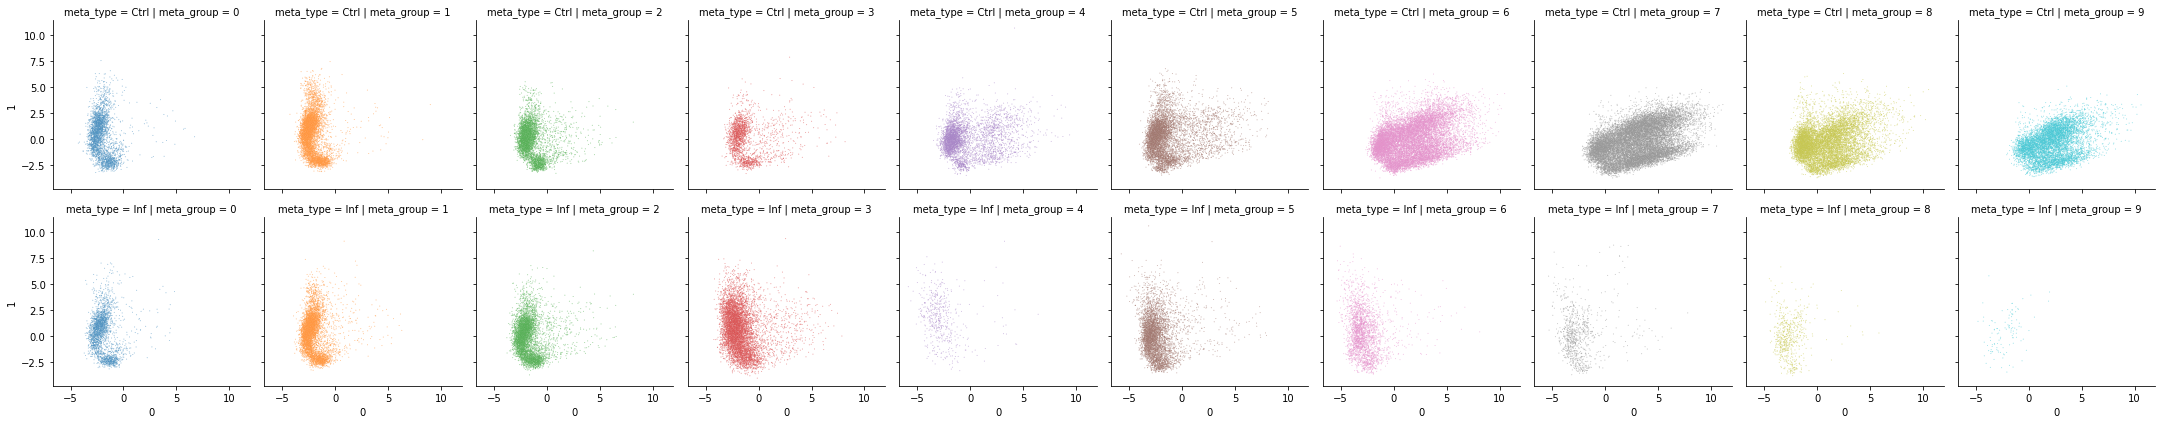

In [20]:
tmp_df = pandas.DataFrame(adata.obsm["X_pca"])
tmp_df.index = df.index
tmp_df["meta_label"] = df["meta_label"]

grid = seaborn.FacetGrid(data=tmp_df.reset_index(), row="meta_type", col="meta_group")
grid.map_dataframe(seaborn.scatterplot, x=0, y=1, hue="meta_group", s=1, alpha=0.5, edgecolors="none")

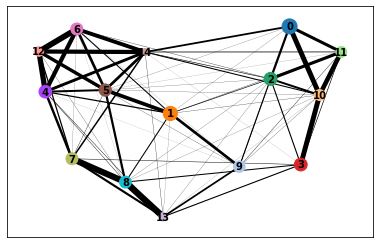

CPU times: user 2min 47s, sys: 452 ms, total: 2min 47s
Wall time: 5min 28s


In [21]:
%%time
scanpy.pp.neighbors(adata, n_neighbors=20)

scanpy.tl.louvain(adata)

scanpy.tl.paga(adata)
scanpy.pl.paga(adata)

scanpy.tl.umap(adata, min_dist=0.1, init_pos="paga")

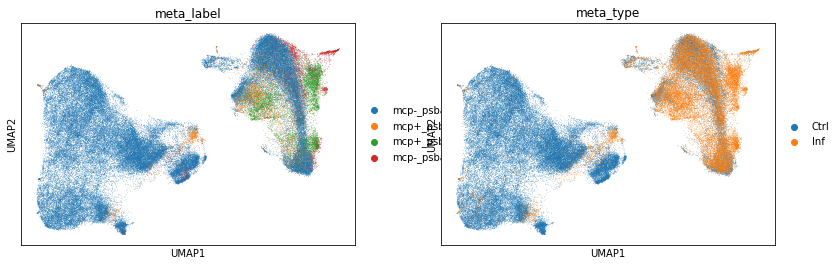

In [22]:
scanpy.pl.umap(adata, color=['meta_label', 'meta_type'])

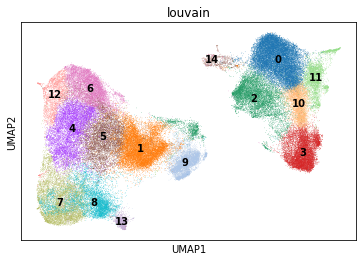

In [23]:
scanpy.pl.umap(adata, color='louvain', legend_loc='on data')

## Major split

<AxesSubplot:xlabel='louvain'>

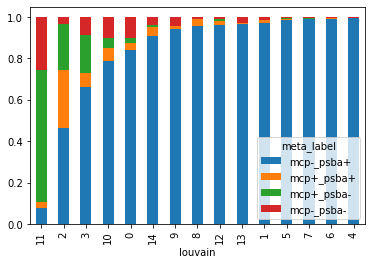

In [24]:
frac_df = (adata.obs.groupby(["louvain", "meta_label"]).size() / adata.obs.groupby("louvain").size()).to_frame(name="frac")
frac_df.reset_index().pivot(index="louvain", columns="meta_label", values="frac").sort_values("mcp-_psba+").plot.bar(stacked=True)

<AxesSubplot:xlabel='louvain'>

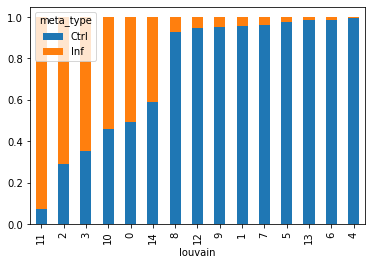

In [25]:
frac_df = (adata.obs.reset_index(drop=True).groupby(["louvain", "meta_type"]).size() / adata.obs.groupby("louvain").size()).to_frame(name="frac")
frac_df.reset_index().pivot(index="louvain", columns="meta_type", values="frac").sort_values("Ctrl").plot.bar(stacked=True)

In [26]:
scanpy.tl.dendrogram(adata, groupby="louvain")
cut_map = cut_tree(adata.uns["dendrogram_louvain"]["linkage"], n_clusters=2).ravel()
adata.obs["louvain_dendro_2"] = adata.obs["louvain"].apply(lambda x: cut_map[int(x)])

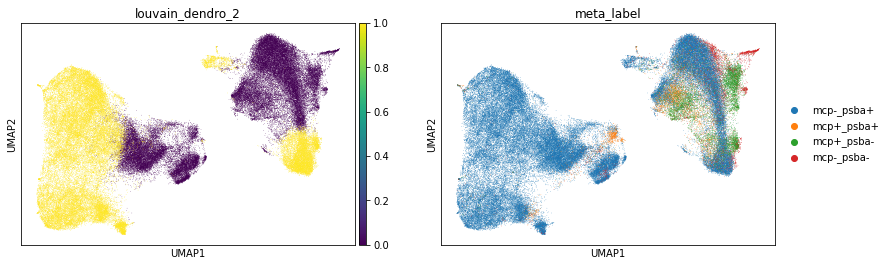

In [27]:
scanpy.pl.umap(adata, color=["louvain_dendro_2", "meta_label"])

Cluster 1 and 2 contain mainly healthy cells. However, they are mapped to a different region in UMAP space. Below, I apply mutual information to identify features that explain this.

In [ ]:
%%time

X = adata.X
target = adata.obs["louvain_dendro_2"]

mi = mutual_info_classif(X, target, n_neighbors=20, random_state=0)
mi = pandas.Series(mi, index=selected).sort_values()
mi.tail(n=20)

<AxesSubplot:xlabel='value', ylabel='variable'>

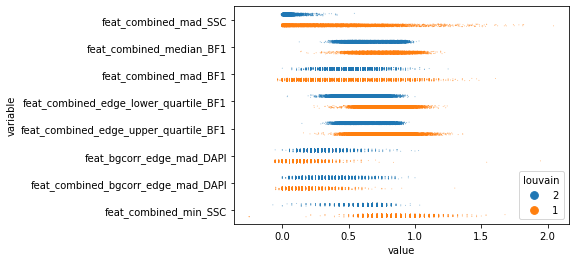

In [34]:
tmp_df = pandas.concat([adata[clust_sel].to_df(), adata.obs[clust_sel]], axis=1)
tmp_df["louvain"] = tmp_df["louvain"].astype(str)
seaborn.stripplot(data=pandas.melt(tmp_df, id_vars=["louvain"], value_vars=mi.tail(n=8).index), hue="louvain", x="value", y="variable", dodge=True, s=1, alpha=.5)

<AxesSubplot:title={'center':'feat_combined_min_SSC'}>

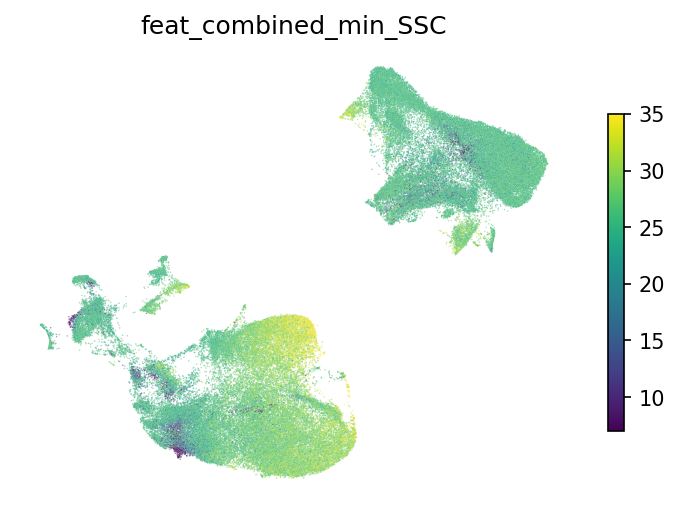

In [35]:
core.color_dimred(adata.obsm["X_umap"], df["feat_combined_min_SSC"])

## Focusing on infection cycle

In [28]:
sel1 = adata.obs["louvain"].isin([str(c) for c in [0, 11, 14, 2, 10, 3]])

In [29]:
adata2 = adata[sel1].copy()
adata2.shape

(44527, 579)

In [30]:
%%time
scanpy.pp.scale(adata2)
scanpy.tl.umap(adata2, min_dist=0.1, random_state=0)

CPU times: user 36.4 s, sys: 76.9 ms, total: 36.5 s
Wall time: 36.8 s


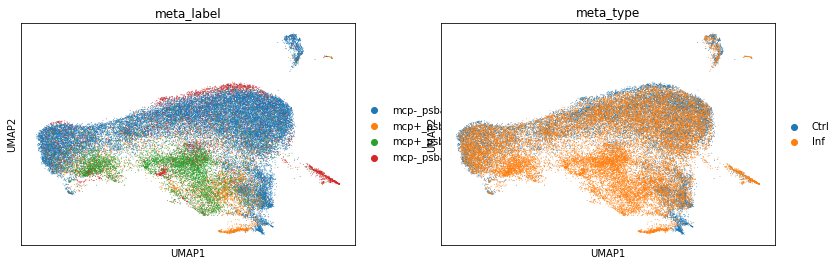

In [31]:
scanpy.pl.umap(adata2, color=['meta_label', 'meta_type'])

ValueError: Expected `colors` to be of length `16`, found `6`.

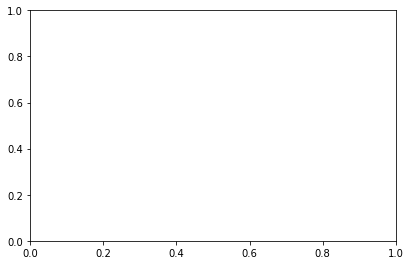

In [34]:
%%time
scanpy.pp.pca(adata2)
scanpy.pp.neighbors(adata2, n_neighbors=30)

scanpy.tl.louvain(adata2, resolution=1.5, random_state=0)

scanpy.tl.paga(adata2, groups="louvain")
scanpy.pl.paga(adata2)

scanpy.tl.umap(adata2, min_dist=0.1, init_pos="paga")

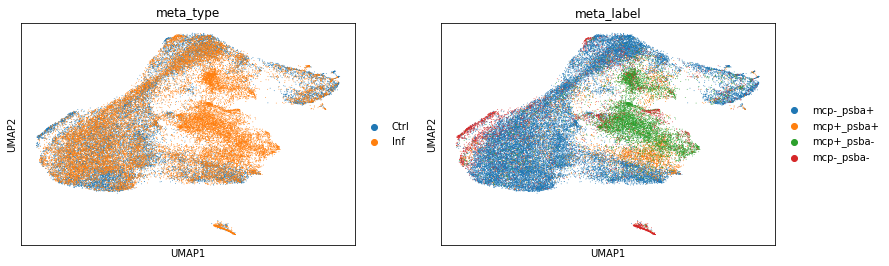

In [117]:
scanpy.pl.umap(adata2, color=["meta_type", "meta_label"])

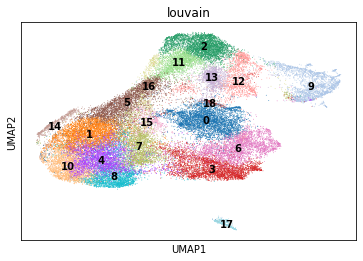

In [118]:
scanpy.pl.umap(adata2, color="louvain", legend_loc="on data")

<AxesSubplot:xlabel='louvain'>

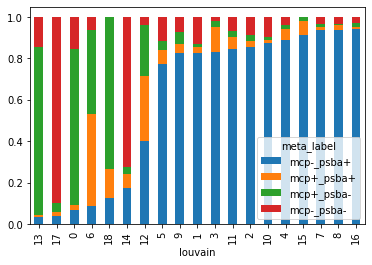

In [119]:
frac_df = (adata3.obs.groupby(["louvain", "meta_label"]).size() / adata3.obs.groupby("louvain").size()).to_frame(name="frac").reset_index()
frac_df.pivot(index="louvain", columns="meta_label", values="frac").sort_values("mcp-_psba+").plot.bar(stacked=True)

In [120]:
"Purity: %.4f" % (adata3.obs.groupby(["louvain", "meta_label"]).size().groupby("louvain").max() / adata3.obs.groupby("louvain").size()).mean()

'Purity: 0.8001'

## Zooming in on structures

### Isolated island

In [182]:
sel_stationary = adata3.obs["louvain"] == "9"

In [163]:
%%time
mi2 = mutual_info_classif(adata3.X, sel_stationary, n_neighbors=10, random_state=0)
mi2 = pandas.Series(mi2, index=selected_mi).sort_values()
mi2.tail(n=20)

CPU times: user 21.7 s, sys: 17.5 ms, total: 21.7 s
Wall time: 21.7 s


feat_combined_bgcorr_edge_lower_quartile_SSC    0.079685
feat_bgcorr_min_SSC                             0.099832
feat_bgcorr_mean_BF1                            0.104722
feat_combined_bgcorr_mean_BF2                   0.115119
feat_combined_bgcorr_sum_BF2                    0.123690
feat_combined_bgcorr_edge_median_SSC            0.129073
feat_combined_bgcorr_sum_BF1                    0.158012
feat_combined_bgcorr_median_SSC                 0.163475
feat_combined_median_SSC                        0.166788
feat_combined_mad_SSC                           0.168745
feat_combined_edge_std_SSC                      0.168985
feat_combined_bgcorr_edge_upper_quartile_SSC    0.169358
feat_combined_edge_upper_quartile_SSC           0.170571
feat_combined_edge_sum_SSC                      0.173643
feat_combined_bgcorr_upper_quartile_SSC         0.174691
feat_sum_SSC                                    0.180008
feat_combined_bgcorr_edge_sum_SSC               0.180012
feat_bgcorr_sum_SSC            

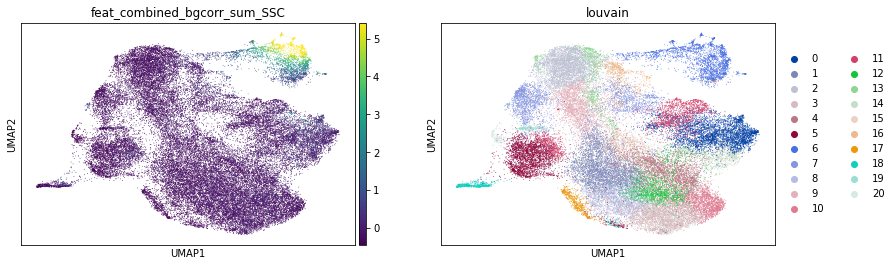

In [183]:
f = mi2.index.values[-1]
qq = numpy.quantile(adata3[:, f].X, (0.01, 0.99))
scanpy.pl.umap(adata3, color=[f, "louvain"], vmin=qq[0], vmax=qq[1])

<AxesSubplot:xlabel='meta_type', ylabel='count'>

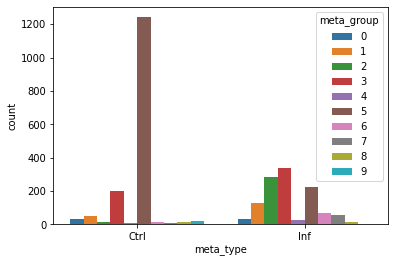

In [184]:
seaborn.countplot(data=adata3.obs[sel_stationary], x="meta_type", hue="meta_group")

### +/- structures

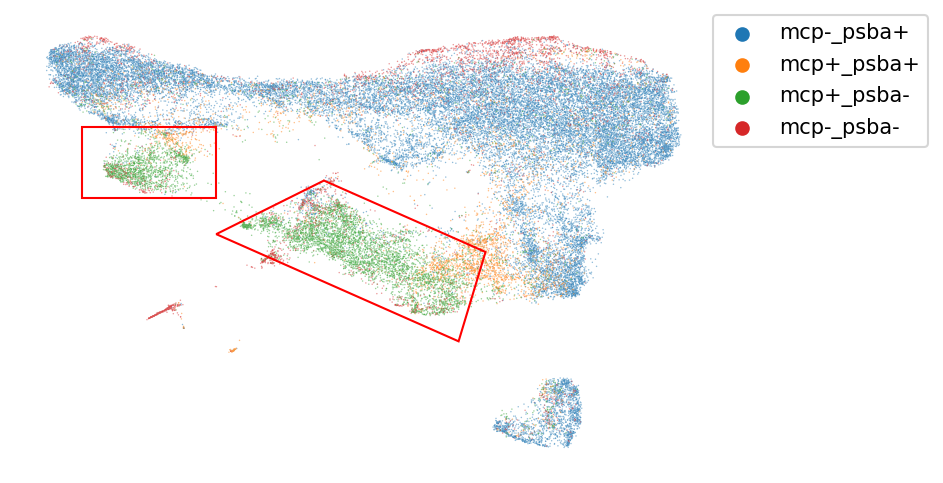

In [80]:
vertices1 = numpy.array([
    [-3, 0],
    [-5.5, 0],
    [-5.5, 2],
    [-3, 2]
])
p1 = Polygon(vertices1, facecolor = 'none', edgecolor="red")

vertices2 = numpy.array([
    [1.5, -4],
    [-3, -1],
    [-1, 0.5],
    [2, -1.5]
])
p2 = Polygon(vertices2, facecolor = 'none', edgecolor="red")

fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], s=0.5, alpha=0.5, edgecolors="none", hue=df["meta_label"], ax=ax)
ax.add_patch(p1)
ax.add_patch(p2)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
ax.set_axis_off()

In [70]:
sel1 = mPath(vertices1).contains_points(umap2_) & (df["meta_label"] == "mcp+_psba-")
sel2 = mPath(vertices2).contains_points(umap2_) & (df["meta_label"] == "mcp+_psba-")

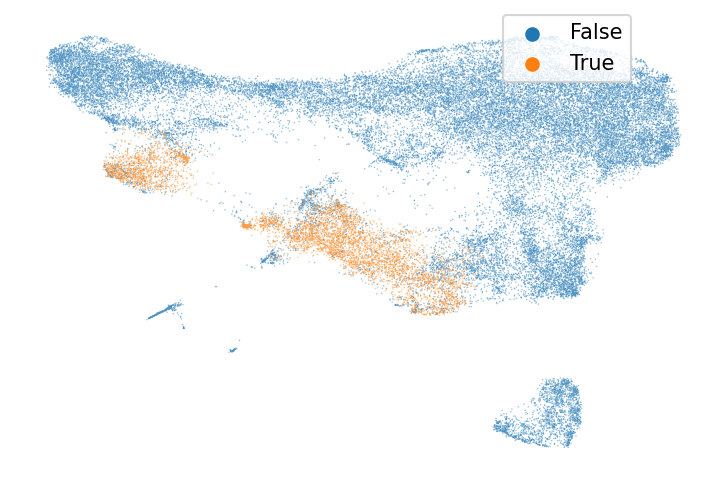

In [71]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], s=0.5, alpha=0.5, edgecolors="none", hue=sel1 | sel2, ax=ax)
plt.legend(bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.)
ax.set_axis_off()

In [73]:
y = numpy.vstack([~(sel1 | sel2), sel1, sel2]).T.argmax(axis=1)

In [74]:
rf = RandomForestClassifier(n_estimators = 100, oob_score=True).fit(df[selected_mi][sel1 | sel2], y[sel1 | sel2])

In [75]:
rf.oob_score_

0.990482664853841

In [ ]:
sortidx = numpy.argsort(rf.feature_importances_)
cols = X.columns[sortidx].values[::-1]

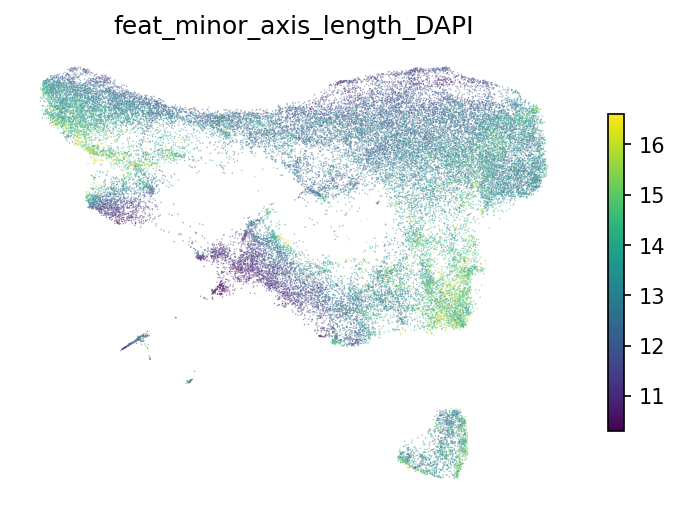

In [77]:
f = cols[0]
fig, ax = plt.subplots(dpi=150)
norm = Normalize(vmin=df[f].quantile(0.01), vmax=df[f].quantile(0.99))
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], s=0.5, alpha=0.5, edgecolors="none", palette="viridis", hue_norm=norm, legend=None, hue=df[f], ax=ax)
ax.set_axis_off()
ax.set_title(f)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, shrink=0.7)

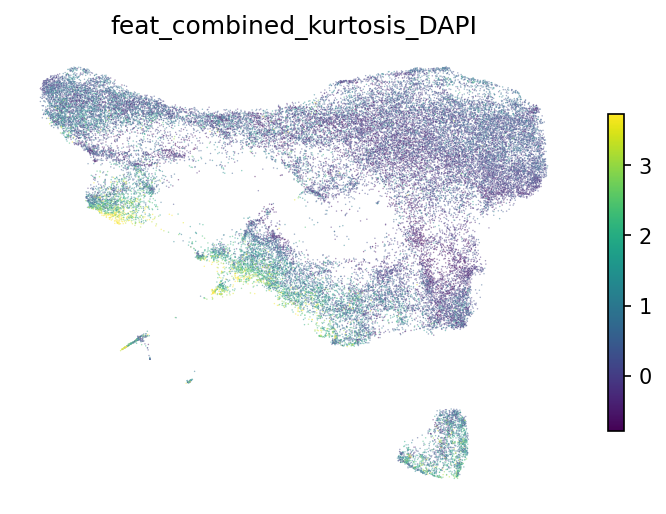

In [78]:
f = cols[1]
fig, ax = plt.subplots(dpi=150)
norm = Normalize(vmin=df[f].quantile(0.01), vmax=df[f].quantile(0.99))
seaborn.scatterplot(x=umap2_[:, 0], y=umap2_[:, 1], s=0.5, alpha=0.5, edgecolors="none", palette="viridis", hue_norm=norm, legend=None, hue=df[f], ax=ax)
ax.set_axis_off()
ax.set_title(f)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, shrink=0.7)

### Dead cells

In [233]:
maj_df = frac_df[frac_df.frac > 0.75]
dead_clust = maj_df[maj_df["meta_label"] == "mcp-_psba-"]["louvain"].tolist()
adata3.obs["dead_clust"] = adata3.obs["louvain"].isin(dead_clust)

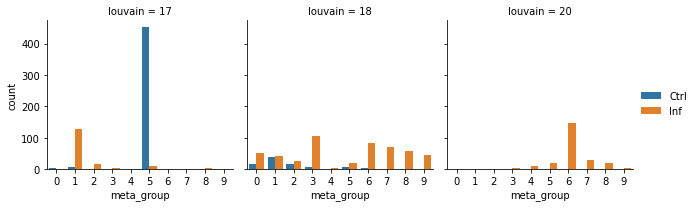

In [230]:
tmp_df = adata3.obs[adata3.obs["dead_clust"]].copy()
tmp_df["louvain"] = tmp_df["louvain"].astype(str)

grid = seaborn.FacetGrid(data=tmp_df, col="louvain")
grid.map_dataframe(seaborn.countplot, x="meta_group", hue="meta_type", palette="tab10")
grid.add_legend()

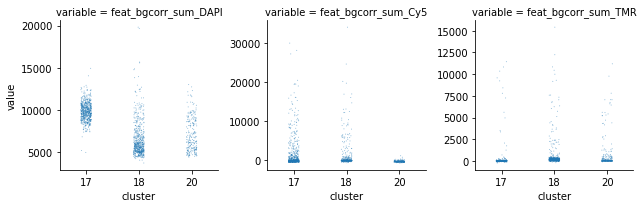

In [232]:
tmp_df = df.loc[adata3.obs.index[adata3.obs["dead_clust"]]][["feat_bgcorr_sum_DAPI", "feat_bgcorr_sum_Cy5", "feat_bgcorr_sum_TMR"]].copy()
tmp_df["cluster"] = adata3.obs[adata3.obs["dead_clust"]]["louvain"].astype(str)

tmp_df = pandas.melt(tmp_df, id_vars=["cluster"], value_vars=["feat_bgcorr_sum_DAPI", "feat_bgcorr_sum_Cy5", "feat_bgcorr_sum_TMR"])

grid = seaborn.FacetGrid(data=tmp_df, col="variable", sharey=False)
grid.map_dataframe(seaborn.stripplot, y="value", x="cluster", s=1, alpha=0.5, dodge=True)

In [236]:
X = adata3[adata3.obs["dead_clust"]].X
y = adata3[adata3.obs["dead_clust"]].obs["louvain"]

rf = RandomForestClassifier(n_estimators = 100, oob_score=True).fit(X, y)
rf.oob_score_

0.9952734638757597

In [241]:
numpy.random.seed(0)
explainer = shap.TreeExplainer(rf)
shap_values = explainer(adata3[adata3.obs["dead_clust"]].to_df())

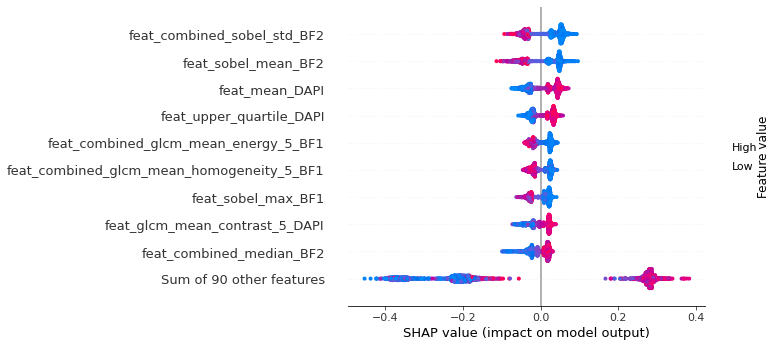

In [242]:
idx = numpy.argsort(shap_values[..., 0].abs.mean(axis=0).values)[::-1]
shap.plots.beeswarm(copy.deepcopy(shap_values[..., 0]), order=idx)

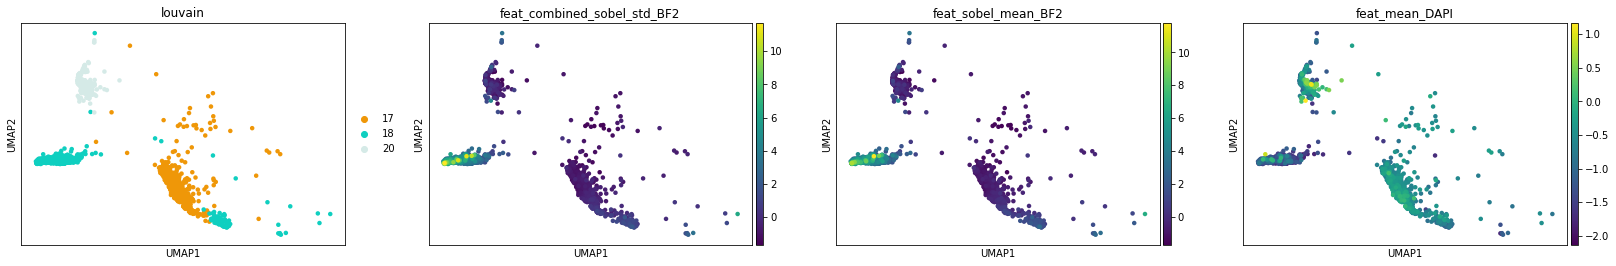

In [248]:
scanpy.pl.umap(adata3[adata3.obs["dead_clust"]], color=["louvain"] + [adata3.var_names[i] for i in idx[:3]])

All-NaN slice encountered
All-NaN slice encountered


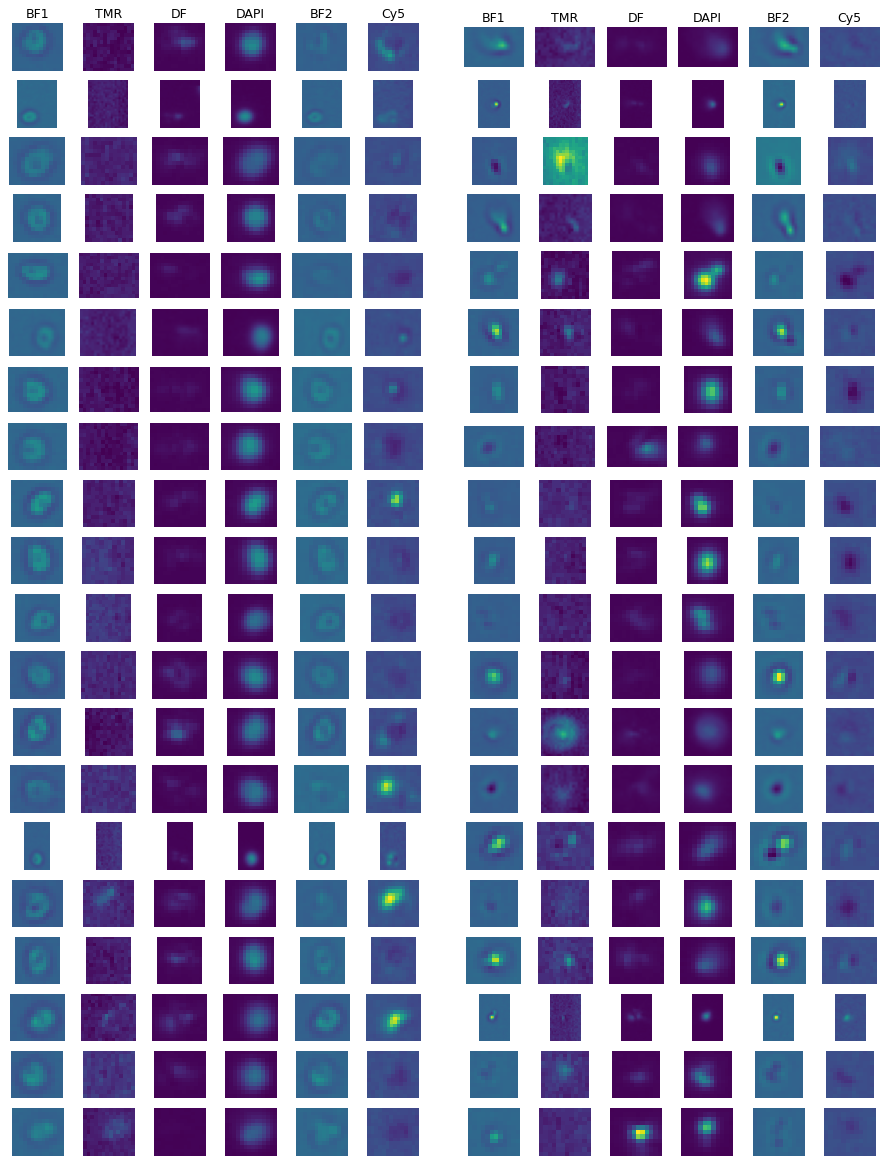

In [117]:
sel_diss_low = (df["feat_combined_glcm_mean_homogeneity_5_BF1"] < 0.25) & sel5
sel_diss_high = (df["feat_combined_glcm_mean_homogeneity_5_BF1"] > .4) & (sel1 | sel2 | sel3)
plot_gate_zarr_channels([sel_diss_low, sel_diss_high], df, maxn=20, smooth=1, mask=False, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "DF", "DAPI", "BF2", "Cy5"])

### Cell cycle trajectory

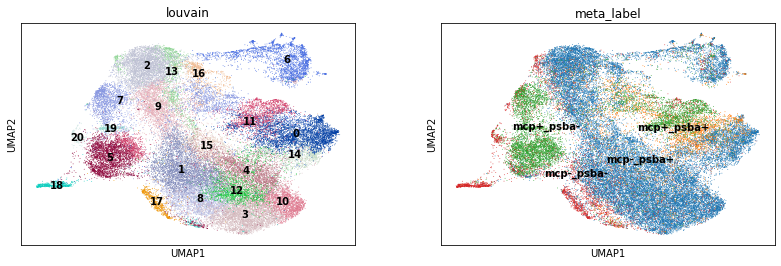

In [250]:
scanpy.pl.umap(adata3, color=["louvain", "meta_label"], legend_loc="on data")

In [260]:
maj_df = frac_df[frac_df.frac > 0.75]
healthy_clust = maj_df[maj_df["meta_label"] == "mcp-_psba+"]["louvain"].tolist()
healthy_clust.remove("6")
adata3.obs["healthy_clust"] = adata3.obs["louvain"].isin(healthy_clust).astype(int)

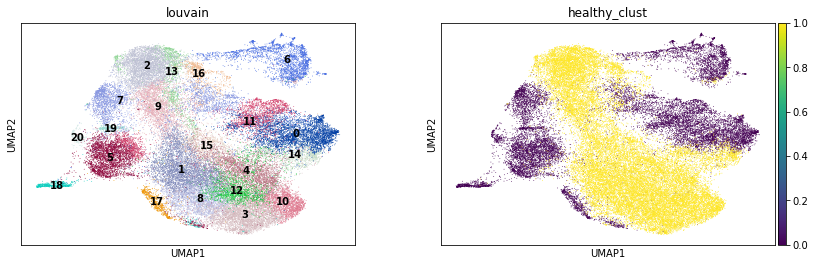

In [261]:
scanpy.pl.umap(adata3, color=["louvain", "healthy_clust"], legend_loc="on data")

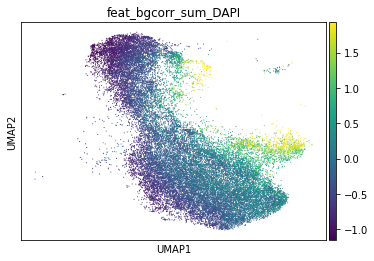

In [268]:
qq = numpy.quantile(adata3[adata3.obs["healthy_clust"] == 1, "feat_bgcorr_sum_DAPI"].X.ravel(), (0.01, 0.99))
scanpy.pl.umap(adata3[adata3.obs["healthy_clust"] == 1], color=["feat_bgcorr_sum_DAPI"], vmin=qq[0], vmax=qq[1])

All-NaN slice encountered
All-NaN slice encountered


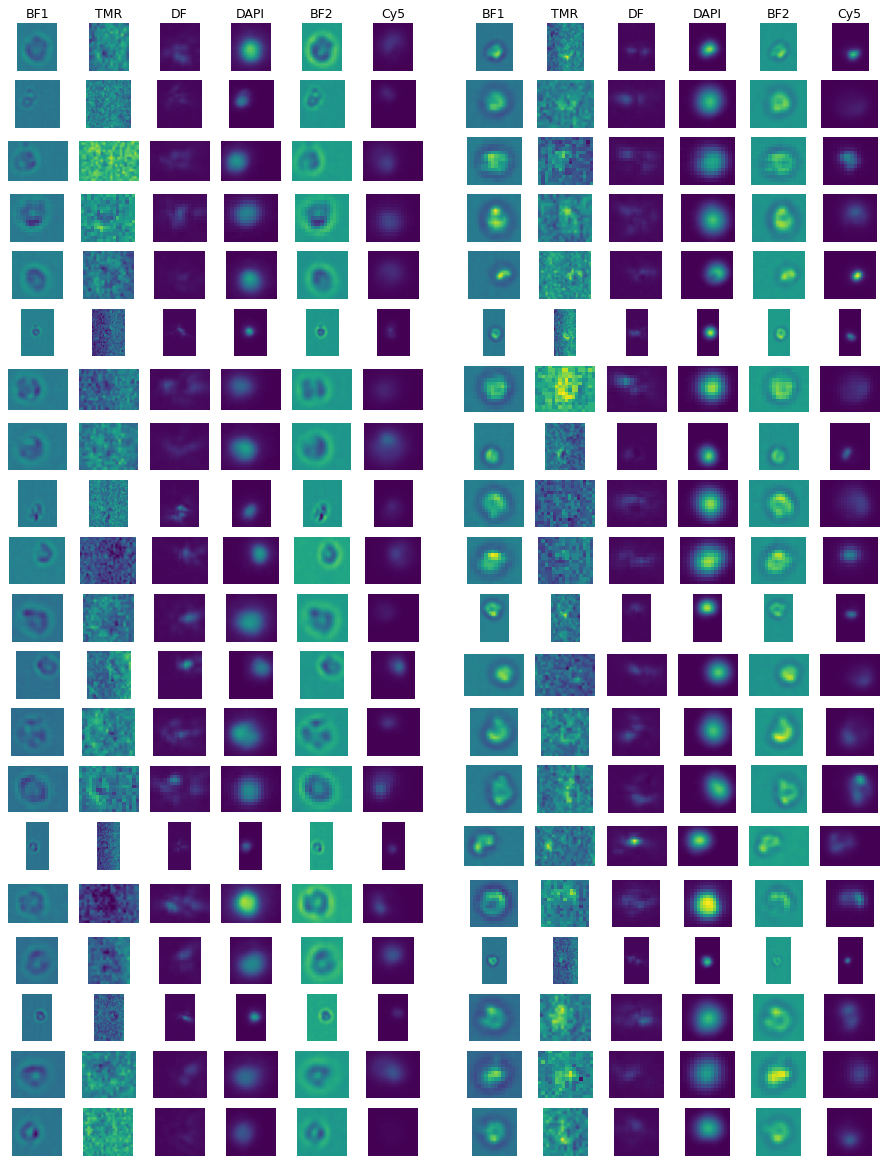

In [157]:
sel_edge_low = sel1 & (df["feat_bgcorr_edge_lower_quartile_BF1"] < -40)
sel_edge_high = sel1 & (df["feat_bgcorr_edge_lower_quartile_BF1"] > 0)
plot_gate_zarr_channels([sel_edge_high, sel_edge_low], df, maxn=20, smooth=1, mask=False, channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "DF", "DAPI", "BF2", "Cy5"])

In [278]:
%%time
sel = adata3.obs["louvain"].isin(["2", "3"])
target = adata3.obs["louvain"][sel] == "2"

mi3 = mutual_info_classif(adata3[sel].X, target, n_neighbors=10, random_state=0)
mi3 = pandas.Series(mi3, index=selected_mi).sort_values()
mi3.tail(n=20)

CPU times: user 3.17 s, sys: 882 µs, total: 3.17 s
Wall time: 3.18 s


feat_combined_max_DAPI                     0.416466
feat_combined_edge_std_DAPI                0.423778
feat_bgcorr_max_DAPI                       0.426179
feat_combined_sobel_mean_DAPI              0.426664
feat_bgcorr_upper_quartile_BF1             0.430218
feat_bgcorr_edge_mad_DAPI                  0.471485
feat_combined_median_BF2                   0.477454
feat_combined_std_BF1                      0.527114
feat_combined_upper_quartile_BF2           0.530208
feat_combined_bgcorr_upper_quartile_BF2    0.570493
feat_combined_edge_lower_quartile_BF2      0.592663
feat_bgcorr_mean_BF1                       0.609142
feat_combined_edge_upper_quartile_BF2      0.609818
feat_combined_bgcorr_lower_quartile_BF1    0.647795
feat_edge_upper_quartile_BF2               0.686083
feat_combined_skewness_BF2                 0.686579
feat_bgcorr_edge_upper_quartile_BF2        0.687571
feat_bgcorr_edge_lower_quartile_BF1        0.688259
feat_combined_bgcorr_edge_sum_BF1          0.689560
feat_combine

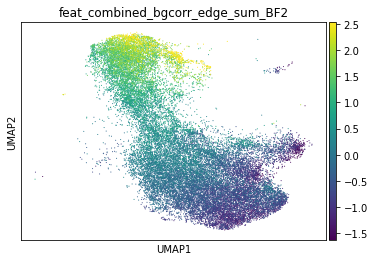

In [279]:
qq = numpy.quantile(adata3[adata3.obs["healthy_clust"] == 1, "feat_combined_bgcorr_edge_sum_BF2"].X.ravel(), (0.01, 0.99))
scanpy.pl.umap(adata3[adata3.obs["healthy_clust"] == 1], color=["feat_combined_bgcorr_edge_sum_BF2"], vmin=qq[0], vmax=qq[1])

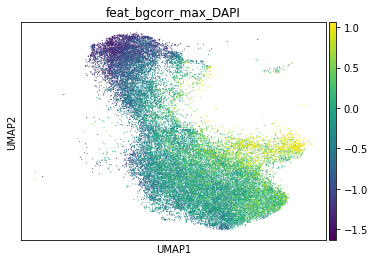

In [280]:
qq = numpy.quantile(adata3[adata3.obs["healthy_clust"] == 1, "feat_bgcorr_max_DAPI"].X.ravel(), (0.01, 0.99))
scanpy.pl.umap(adata3[adata3.obs["healthy_clust"] == 1], color=["feat_bgcorr_max_DAPI"], vmin=qq[0], vmax=qq[1])

## Trajectory analysis

In [306]:
%%time
scanpy.tl.diffmap(adata3)

CPU times: user 1.54 s, sys: 139 ms, total: 1.68 s
Wall time: 1.7 s


In [314]:
adata3.uns['iroot'] = numpy.flatnonzero(adata3.obs["louvain"] == "2")[0]

In [334]:
scanpy.tl.dpt(adata3, n_branchings=1)

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


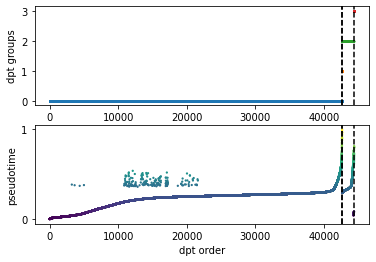

In [336]:
scanpy.pl.dpt_groups_pseudotime(adata3)

In [339]:
adata3.obs["dpt_groups"].unique()

['0', '2', '3', '1']
Categories (4, object): ['0', '1', '2', '3']

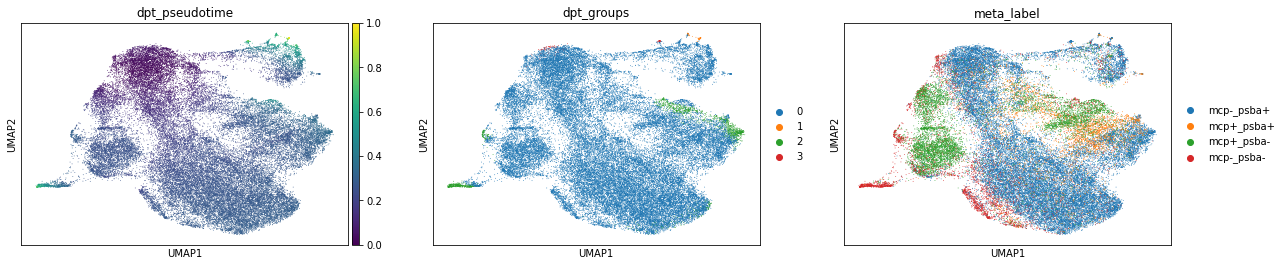

In [340]:
scanpy.pl.umap(adata3, color=["dpt_pseudotime", "dpt_groups", "meta_label"])

## Export

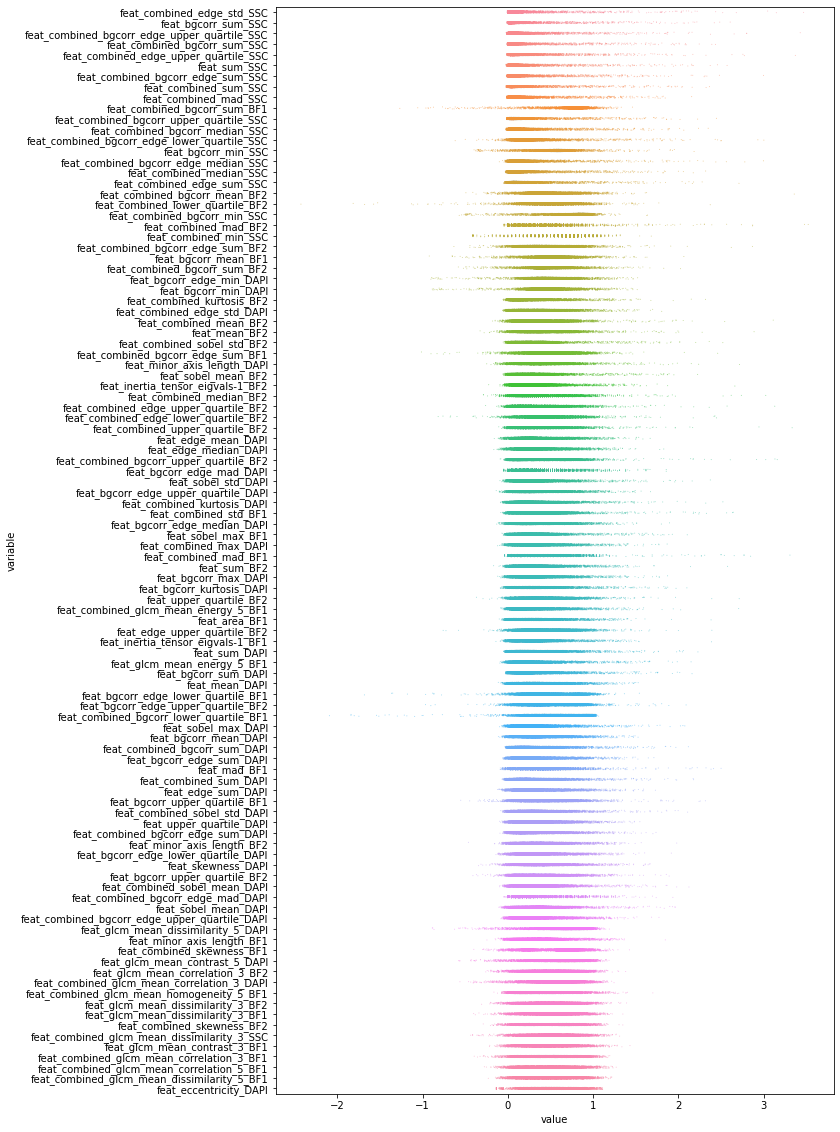

In [115]:
_ = normalization.dists(mm_df[selected_mi])

In [36]:
numpy.save(data_dir / "indices/cluster_index.npy", mm_df[selected_mi][~sel_stationary].index)

In [35]:
df.head()

meta_path  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                                                      
Ctrl      21766              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          19432              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          16719              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          19692              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   
          17745              3              NaN         5           /data/gent/vo/000/gvo00070/vsc42015/datasets/w...   

                                                                    meta_zarr_idx  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                  
Ctrl      21766              3              NaN         5                    1000   
          19432              3              NaN         5                    1001   
          16719              3              NaN         5                    1002   
          19692              3              NaN         5                    1003   
          17745              3              NaN         5                    1005   

                                                                    meta_bbox_minr  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                      3.0   
          19432              3              NaN         5                      3.0   
          16719              3              NaN         5                      1.0   
          19692              3              NaN         5                     12.0   
          17745              3              NaN         5                      0.0   

                                                                    meta_bbox_minc  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                      8.0   
          19432              3              NaN         5                      6.0   
          16719              3              NaN         5                     10.0   
          19692              3              NaN         5                      7.0   
          17745              3              NaN         5                      2.0   

                                                                    meta_bbox_maxr  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                     44.0   
          19432              3              NaN         5                     28.0   
          16719              3              NaN         5                     47.0   
          19692              3              NaN         5                     26.0   
          17745              3              NaN         5                     35.0   

                                                                    meta_bbox_maxc  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                   
Ctrl      21766              3              NaN         5                     31.0   
          19432              3              NaN         5                     23.0   
          16719              3              NaN         5                     47.0   
          19692              3              NaN         5                     23.0   
          17745              3              NaN         5                     26.0   

                                                                    meta_regions_BF1  \
meta_type meta_object_number meta_replicate meta_suffix meta_group                     
Ctrl      21766              3              NaN         5                   

In [116]:
# flowsom

out_df2 = mm_df[selected_mi][~sel_stationary].copy()
out_df2["meta_label"] = df["meta_label"]
out_df2.reset_index().to_feather(path=data_dir / "cells_scaled.feather")

In [117]:
%%time
pca = PCA(n_components=0.95).fit_transform(mm_df[selected_mi][~sel_stationary])

CPU times: user 454 ms, sys: 34.8 ms, total: 489 ms
Wall time: 491 ms


In [118]:
slingshot_df = pandas.DataFrame(
    data=numpy.hstack([pca, umap2_[~sel_stationary]]),
    columns=[f"pca_{i}" for i in range(len(pca.T))] + [f"umap_{i}" for i in range(len(umap2_.T))]
)

In [119]:
slingshot_df.to_feather(data_dir / "slingshot.feather")

## Plots

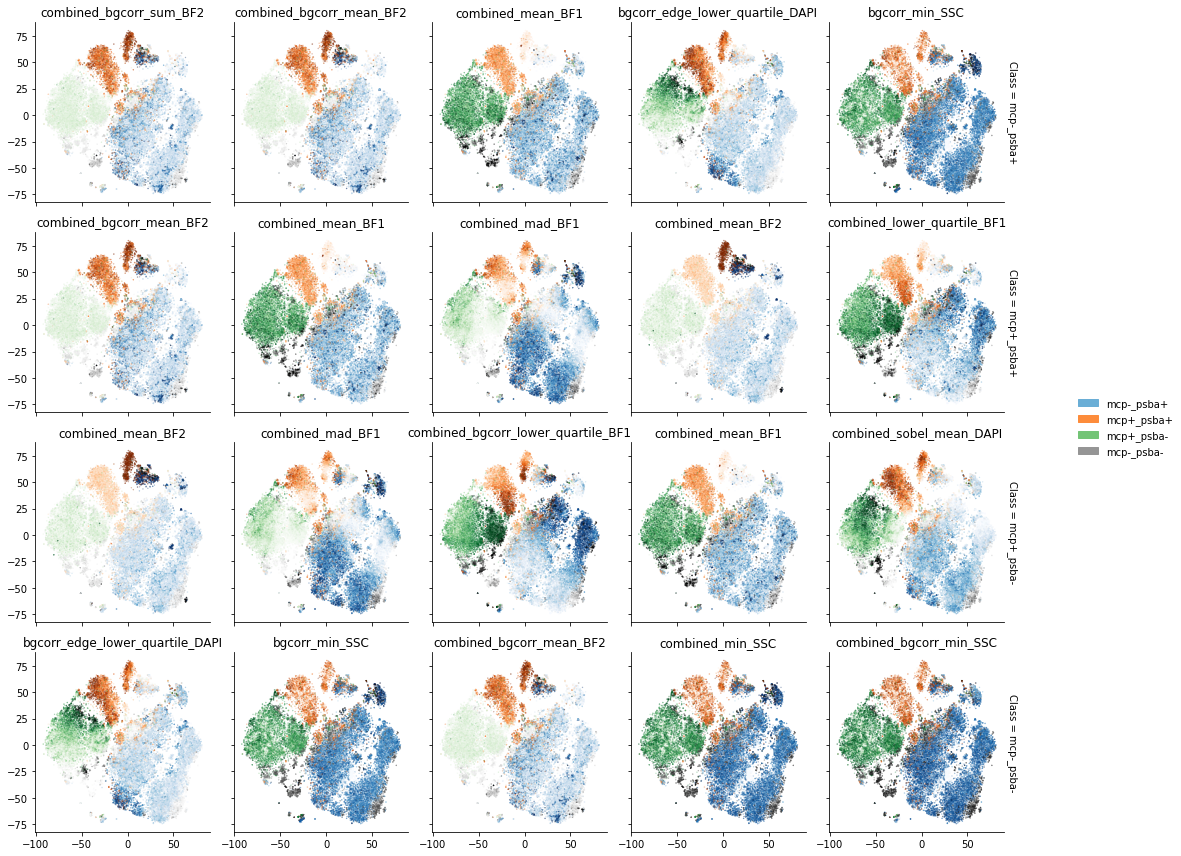

In [106]:
import matplotlib.patches as mpatches

def draw_dimred(data, x, *args, **kwargs):
    f = data[x].iloc[0][len("scip_"):]
    ax = plt.gca()
    norm = matplotlib.colors.Normalize(vmin=df.loc["Inf"][f].quantile(0.05), vmax=df.loc["Inf"][f].quantile(0.95))
    
    for cat, cmap in zip(df["meta_label"].cat.categories, ["Blues", "Oranges", "Greens", "Greys"]):
        sel = df.loc["Inf"]["meta_label"] == cat
        ax.scatter(x=tsne[sel, 0], y=tsne[sel, 1], cmap=cmap, norm=norm, c=df.loc["Inf"][sel][f], s=0.1, alpha=0.5)

grid = seaborn.FacetGrid(data=top5, row="Class", col="Rank", margin_titles=True)

legend_data = {}
for cat, cmap in zip(df["meta_label"].cat.categories, ["Blues", "Oranges", "Greens", "Greys"]):
    legend_data[cat] = mpatches.Patch(color=plt.get_cmap(cmap)(0.5), label=cat)
grid.add_legend(legend_data=legend_data)

grid.map_dataframe(draw_dimred, x="Feature")
for (c, r), ax in grid.axes_dict.items():
    f = top5.set_index(["Class", "Rank"]).loc[c, r]["Feature"]
    ax.set_title(f[len("scip_feat_"):])
    
grid.set_xlabels("")
grid.tight_layout()

plt.savefig(data_dir / "figures/tsne_color_top5_shap.png", bbox_inches="tight", dpi=150)

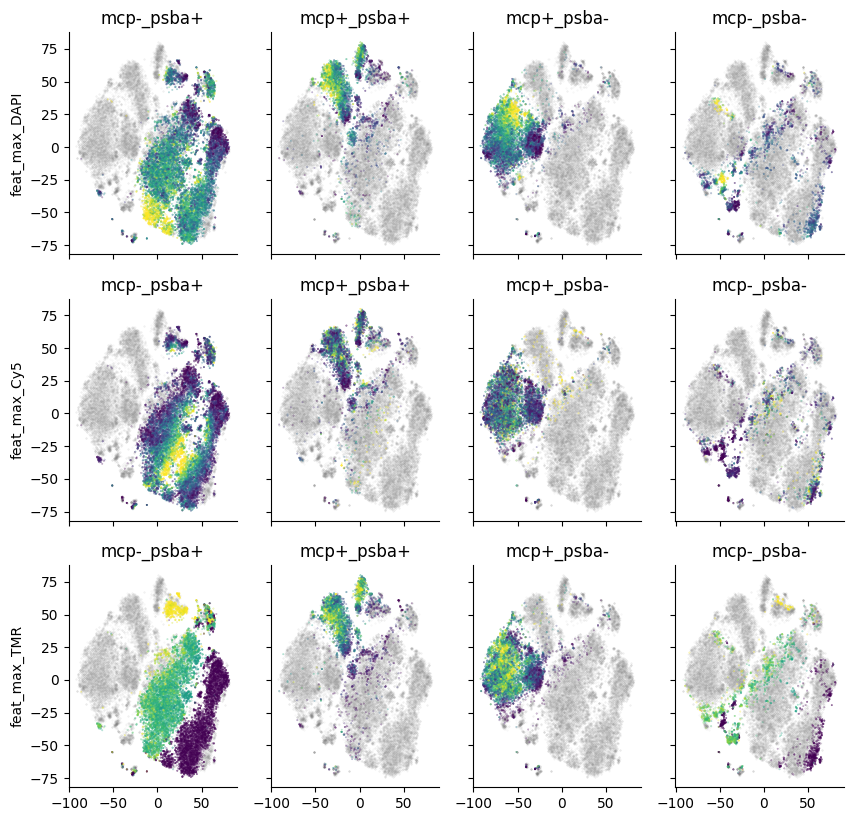

In [107]:
fig, axes = plt.subplots(3, 4, dpi=100, figsize=(10, 10), sharex=True, sharey=True)

for f, row in zip(["feat_max_DAPI", "feat_max_Cy5", "feat_max_TMR"], axes):

    row[0].set_ylabel(f)
    for ax, cat in zip(row, df["meta_label"].cat.categories):
        sel = df.loc["Inf"]["meta_label"] == cat
        norm = matplotlib.colors.Normalize(vmin=df.loc["Inf"][sel][f].quantile(0.05), vmax=df.loc["Inf"][sel][f].quantile(0.95))
        ax.scatter(x=tsne[~sel, 0], y=tsne[~sel, 1], c="grey", s=0.1, alpha=0.1)
        ax.scatter(x=tsne[sel, 0], y=tsne[sel, 1], cmap="viridis", norm=norm, c=df.loc["Inf"][sel][f], s=0.1, alpha=0.5)
        ax.set_title(cat)

seaborn.despine(fig)

plt.savefig(data_dir / "figures/tsne_color_fluor.png", bbox_inches="tight", dpi=150)